# <ins>Predicting Poetic Movements</ins>

## Modeling

### Using Naive Bayes, Decision Tree, Random Forest, and SVM

### NOTE: Currently working on revamping/organizing. Thank you for understanding :)

## Table of contents

1. [Introduction](#Introduction)
2. [The problem domain](#The-problem-domain)
3. [Required libraries](#Required-libraries)
4. [Step 1: Preparing the data](#Step-1:-Preparing-the-data)
    
    - [Multicollinearity](#Multicollinearity)
    - [Dealing with outliers](#Dealing-with-outliers)
    - [Save/Load DataFrame](#💾-Save/Load-DataFrame)
    - [Train-test split](#Train-test-split)
    - [Vectors DataFrame](#Vectors-DataFrame)
    - [Combo DataFrame](#Combo-DataFrame)
    
    
5. [Step 2: Modeling](#Step-2:-Modeling)

    - [Baseline model (Naive Bayes)](#Baseline-model-(Naive-Bayes))
    - [K-Nearest Neighbors](#K-Nearest-Neighbors)
    - [Decision Tree](#Decision-Tree)
    - [Random Forest](#Random-Forest)
    - [SVM](#SVM)
        - [Parameter tuning](#Parameter-tuning)
        - [Train final model](#Train-final-model)
    
    
6. [Step 3: Reproducibility](#Step-3:-Reproducibility)

    - [NLP + Model version](#NLP-+-Model-version)
    - [Model only version](#Model-only-version)
    
    
7. [Conclusions](#Conclusions)
8. [Acknowledgements](#Acknowledgements)

## Introduction

[[go back to the top](#Predicting-Poetic-Movements)]

After [scraping](01_webscraping.ipynb) PoetryFoundation.org for genre-labeled poems and [cleaning](02_data_cleaning.ipynb), I used [natural language processing (NLP)](03_nlp_features_eda.ipynb) techniques to analyze poetic structure across poetic genres and movements. 

Through text processing, exploratory data analysis, and feature engineering, I looked for insights into how poetic structure, word usage, lexical richness, and sentiment relate to the genre of a poem.

In this notebook, I will create predictive models that classify poems into one of four umbrella movements: *Avant-Garde*, *Metropolitan*, *Modern*, or *Pre-1900*. This will help provide further insight and confirm my findings during EDA.

The ultimate goal is to create a recommendation system that compares poem similarities and recommends individual poems to users. *(NOTE: To skip to the recommendation system notebook, click [here](05_recommendation_system.ipynb))*.

## The problem domain

[[go back to the top](#Predicting-Poetic-Movements)]

Within written media, poetry is often regarded as enigmatic, frivolous, or too niche. As a result, poems (even by established poets) are often overlooked by larger publishers and literature-focused websites alike. (The anti-capitalist nature of poetry may play a role here as well). There are services for rating and recommending entire books (including poetry collections, to be fair) like GoodReads, Amazon, or Bookish, but to my knowledge, there aren't any sites or services that recommend poems on an individual level.

With this in mind, I wondered how poem recommendation may even work. One often finds a genre or two that they like and searches that out, but there must be elements of poetry that transcend genre. If there are, machine learning seems like a perfect tool to use to find them. As a poet and writer, I am interested in creating something that will allow me to discover genres and movements that I may have previously ignored. I can do this by using poems I already know and enjoy to find similar poems from genres I may not know as well.

## Required libraries

[[go back to the top](#Predicting-Poetic-Movements)]

This notebook uses several Python packages that come standard with the Anaconda Python distribution. Libraries within this category that I'll be using are:

- **numpy**: Provides a fast numerical array structure and helper functions.
- **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
- **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
- **seaborn**: Advanced statistical plotting library.
- **scipy**: The essential statistical analysis package in Python.
- **collections**: A package with specialized and higher-performance data structures.
- **warnings**: A helpful package to ignore warnings that unnecessarily clutter the notebook.
- **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.

This notebook also uses some additional packages that you may have to install:

- **nltk**: The essential natural language processing package.
- **gensim**: A more specialized natural language processing package.
- **pickle**: Package to save a file as a byte stream.
- **gzip**: Package to compress/unpack files.

Finally, included within the repository, and necessary to run this workbook, is:
- **[functions](functions.py)**: Custom functions that I built for this project.

Required within the functions file are:
- **itertools**: An package aiding in advanced iteration techniques.
- **regex**: The essential string matching and capturing package.
- **string**: A package with string-specific operations and characters.
- **pronouncing**: A package utilizing the CMU Pronouncing Dictionary that can break language down by syllable, rhyme, and meter.
- **textblob**: A supplementary package to enhance the nltk package.

In [172]:
# custom functions for this project
from functions import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

# text processing
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse

# modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# from keras.models import Sequential
# from keras.layers import Dense, LSTM, Bidirectional
# from keras.layers.embeddings import Embedding
# from keras.preprocessing import sequence

# miscellany
import time
from tqdm import tqdm
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore sklearn/tensorflow warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Step 1: Preparing the data

[[go back to the top](#Predicting-Poetic-Movements)]

- Look for any highly correlated variables, to fight against the curse of dimensionality.
- Deal with any outlier data.

#### 💾 Load DataFrame

In [2]:
# uncomment to load
with gzip.open('data/poetry_movements_df.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [3]:
df.columns

Index(['poet', 'poem_url', 'title', 'poem_lines', 'poem_string', 'genre',
       'movement', 'clean_lines', 'num_lines', 'lines_titled', 'num_words',
       'avg_len_line', 'string_titled', 'sentiment_polarity_score',
       'sentiment_polarity', 'sentiment_subjectivity_score', 'num_end_rhymes',
       'end_rhyme_ratio', 'end_rhyme', 'avg_syllables_word',
       'lexical_richness', 'string_cleaned'],
      dtype='object')

In [4]:
# check out the class balance
df.movement.value_counts(normalize=True)

modern          0.288832
metropolitan    0.248665
pre_1900        0.240771
avant_garde     0.221732
Name: movement, dtype: float64

### Multicollinearity

[[go back to the top](#Predicting-Poetic-Movements)]

In [5]:
# list of continuous variables
cont_cols = [
    'num_lines', 'num_words', 'avg_len_line', 
    'sentiment_polarity_score', 'sentiment_subjectivity_score', 
    'num_end_rhymes', 'end_rhyme_ratio', 'avg_syllables_word', 
    'lexical_richness'
]

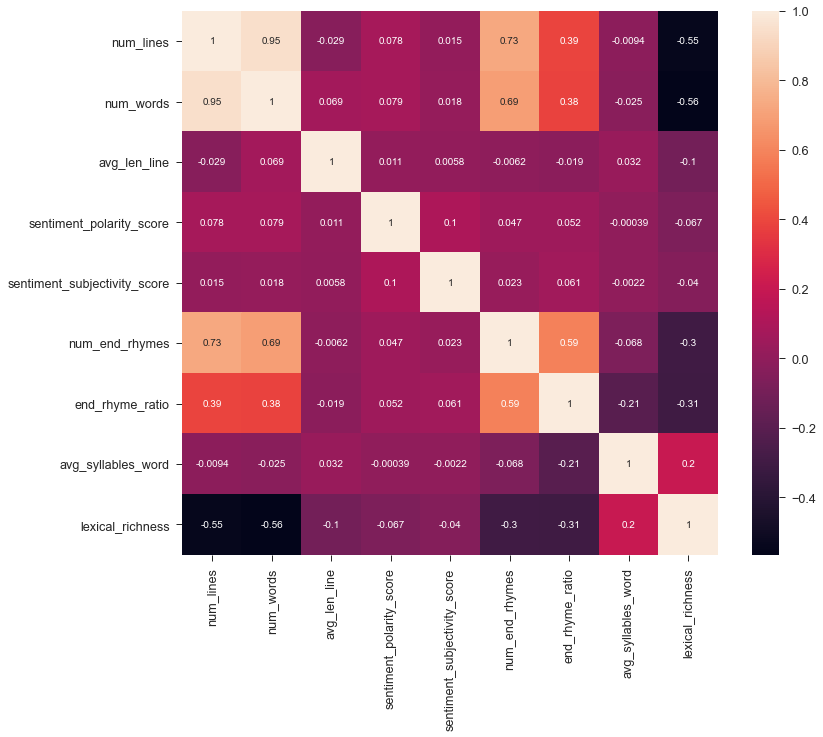

In [6]:
# plot correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df[cont_cols].corr(), annot=True);

- As seen in the [previous notebook](03_nlp_features_eda.ipynb), the number of lines (```num_lines```) and number of words (```num_words```) in a poem are very highly correlated.
    - I'll drop ```num_words```, as the number of lines is a more widely used metric for the length of a poem.
- The number of end rhymes (```num_end_rhymes```) is also rather highly correlated with ```num_lines```, so it's worth considering dropping that.
    - I found the ratio of end rhymes to the number of lines (```end_rhyme_ratio```) to be more statistically significant than the number of end rhymes, so I'd prefer to use that as my end rhyme metric anyway.

In [7]:
# new list of continuous variables
cont_cols = [
    'num_lines', 'avg_len_line', 'sentiment_polarity_score', 
    'sentiment_subjectivity_score', 'end_rhyme_ratio', 
    'avg_syllables_word', 'lexical_richness'
]

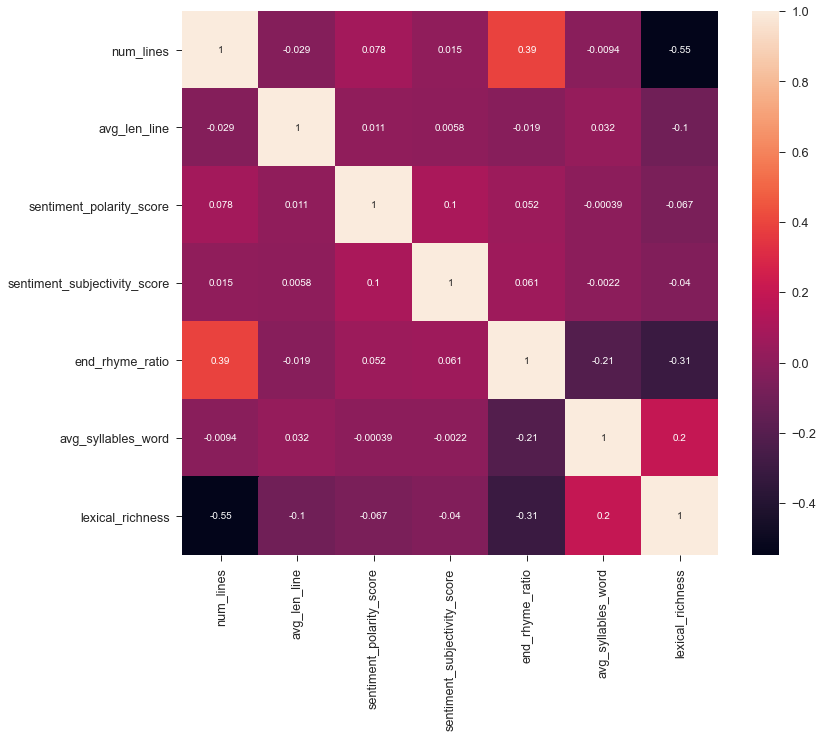

In [8]:
# plot correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df[cont_cols].corr(), annot=True);

### Dealing with outliers

[[go back to the top](#Predicting-Poetic-Movements)]

- Cap or floor outlier values as necessary.

In [9]:
# make a copy for which I can rein in outlier values
df_capped = df.copy()

In [10]:
# find the outlier thresholds (using winsorization)
min_thresh = df[cont_cols].quantile(0.05)
max_thresh = df[cont_cols].quantile(0.95)
print(min_thresh)
print('-' * 42)
print(max_thresh)

num_lines                       7.000000
avg_len_line                    3.346818
sentiment_polarity_score       -0.970270
sentiment_subjectivity_score    0.257885
end_rhyme_ratio                 0.000000
avg_syllables_word              1.092393
lexical_richness                0.440678
Name: 0.05, dtype: float64
------------------------------------------
num_lines                       131.700000
avg_len_line                      9.750000
sentiment_polarity_score          0.995900
sentiment_subjectivity_score      0.687500
end_rhyme_ratio                   1.009091
avg_syllables_word                1.372212
lexical_richness                  0.850402
Name: 0.95, dtype: float64


#### Number of lines

In [11]:
# descriptive stats
df.num_lines.describe()

count    4307.000000
mean       40.269561
std        63.118049
min         1.000000
25%        14.000000
50%        22.000000
75%        40.000000
max       892.000000
Name: num_lines, dtype: float64

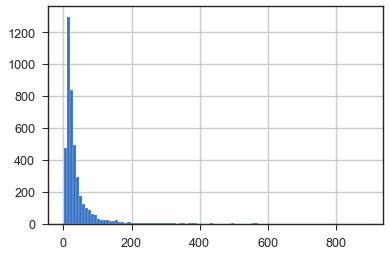

In [12]:
# current distribution
df.num_lines.hist(bins=100);

In [13]:
# cap/floor outliers
df_capped['num_lines'] = winsorizer(df['num_lines'])

# descriptive stats
df_capped['num_lines'].describe()

count    4307.000000
mean       34.295147
std        31.983861
min         7.000000
25%        14.000000
50%        22.000000
75%        40.000000
max       131.700000
Name: num_lines, dtype: float64

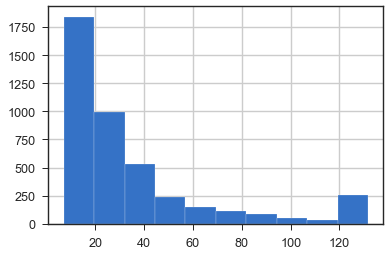

In [14]:
# new distribution
df_capped.num_lines.hist();

#### Average words per line

In [15]:
# descriptive stats
df.avg_len_line.describe()

count    4307.000000
mean        8.449181
std        37.933747
min         1.000000
25%         5.260870
50%         6.527778
75%         7.714286
max      1403.000000
Name: avg_len_line, dtype: float64

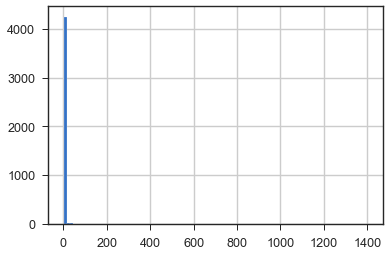

In [16]:
# current distribution
df.avg_len_line.hist(bins=100);

In [17]:
# cap/floor outliers
df_capped['avg_len_line'] = winsorizer(df['avg_len_line'])

# descriptive stats
df_capped['avg_len_line'].describe()

count    4307.000000
mean        6.494119
std         1.721049
min         3.346818
25%         5.260870
50%         6.527778
75%         7.714286
max         9.750000
Name: avg_len_line, dtype: float64

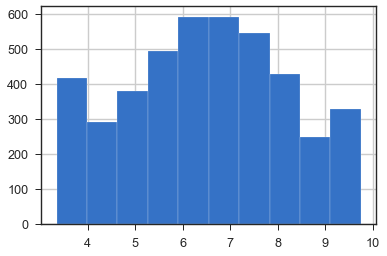

In [18]:
# new distribution
df_capped.avg_len_line.hist();

#### End rhyme ratio

In [19]:
# descriptive stats
df.end_rhyme_ratio.describe()

count    4307.000000
mean        0.302165
std         0.561589
min         0.000000
25%         0.000000
50%         0.127389
75%         0.416667
max        13.846154
Name: end_rhyme_ratio, dtype: float64

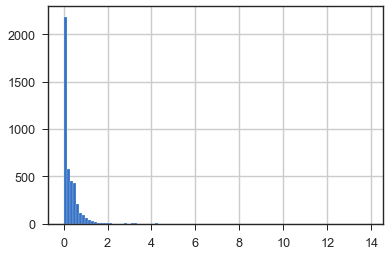

In [20]:
# current distribution
df.end_rhyme_ratio.hist(bins=100);

In [21]:
# cap/floor outliers
df_capped['end_rhyme_ratio'] = winsorizer(df['end_rhyme_ratio'])

# descriptive stats
df_capped['end_rhyme_ratio'].describe()

count    4307.000000
mean        0.254074
std         0.293332
min         0.000000
25%         0.000000
50%         0.127389
75%         0.416667
max         1.009091
Name: end_rhyme_ratio, dtype: float64

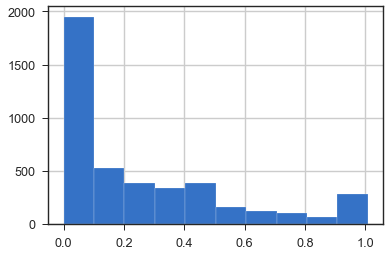

In [22]:
# new distribution
df_capped.end_rhyme_ratio.hist();

#### Average number of syllables per word

In [23]:
# descriptive stats
df.avg_syllables_word.describe()

count    4307.000000
mean        1.214609
std         0.087841
min         1.000000
25%         1.155752
50%         1.204545
75%         1.261905
max         1.771930
Name: avg_syllables_word, dtype: float64

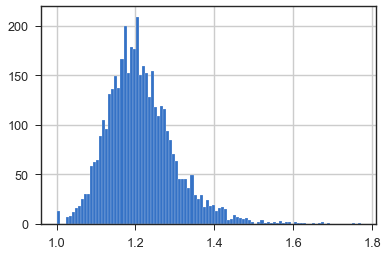

In [24]:
# current distribution
df.avg_syllables_word.hist(bins=100);

In [25]:
# cap/floor outliers
df_capped['avg_syllables_word'] = winsorizer(df['avg_syllables_word'])

# descriptive stats
df_capped['avg_syllables_word'].describe()

count    4307.000000
mean        1.212364
std         0.075228
min         1.092393
25%         1.155752
50%         1.204545
75%         1.261905
max         1.372212
Name: avg_syllables_word, dtype: float64

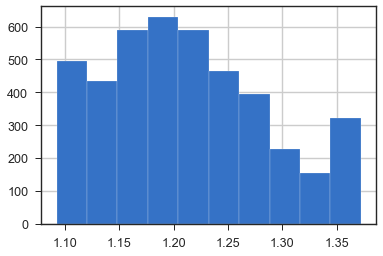

In [26]:
# new distribution
df_capped.avg_syllables_word.hist();

#### Lexical richness

In [27]:
# descriptive stats
df.lexical_richness.describe()

count    4307.000000
mean        0.657667
std         0.125099
min         0.066667
25%         0.580302
50%         0.666667
75%         0.740260
max         1.000000
Name: lexical_richness, dtype: float64

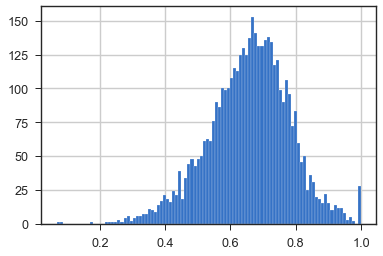

In [28]:
# current distribution
df.lexical_richness.hist(bins=100);

In [29]:
# cap/floor outliers
df_capped['lexical_richness'] = winsorizer(df['lexical_richness'])

# descriptive stats
df_capped['lexical_richness'].describe()

count    4307.000000
mean        0.658047
std         0.111326
min         0.440678
25%         0.580302
50%         0.666667
75%         0.740260
max         0.850402
Name: lexical_richness, dtype: float64

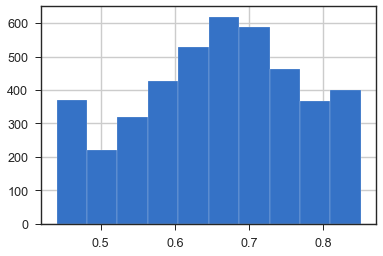

In [30]:
# new distribution
df_capped.lexical_richness.hist();

#### Subjectivity score

In [31]:
# descriptive stats
df.sentiment_subjectivity_score.describe()

count    4307.000000
mean        0.478008
std         0.135322
min         0.000000
25%         0.410284
50%         0.484470
75%         0.550000
max         1.000000
Name: sentiment_subjectivity_score, dtype: float64

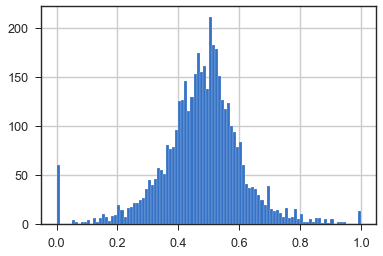

In [32]:
# current distribution
df.sentiment_subjectivity_score.hist(bins=100);

In [33]:
# cap/floor outliers
df_capped['sentiment_subjectivity_score'] = winsorizer(df['sentiment_subjectivity_score'])

# descriptive stats
df_capped['sentiment_subjectivity_score'].describe()

count    4307.000000
mean        0.479417
std         0.109112
min         0.257885
25%         0.410284
50%         0.484470
75%         0.550000
max         0.687500
Name: sentiment_subjectivity_score, dtype: float64

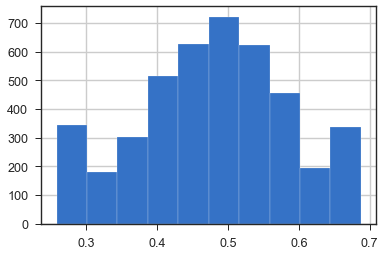

In [34]:
# new distribution
df_capped.sentiment_subjectivity_score.hist();

### 💾 Save/Load DataFrame

[[go back to the top](#Predicting-Poetic-Movements)]

In [35]:
# # uncomment to save
# with gzip.open('data/poetry_movements_df_capped.pkl', 'wb') as goodbye:
#     pickle.dump(df_capped, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/poetry_movements_df_capped.pkl', 'rb') as hello:
#     df_capped = pickle.load(hello)

### Train-test split

[[go back to the top](#Predicting-Poetic-Movements)]

- Create features DataFrame and target series.
    - While removing stop words was helpful for EDA in the [previous notebook](#03_nlp_features_eda.ipynb#Step-4:-Natural-language-processing), I'll refrain from doing that here, which should result in more accurate models. Using a TF-IDF vectorizer renders frequent words (i.e. words generally among the stop words list) less relevant.
- Use 75% of the data as a training set and 25% as a testing set.
- Since I want to see if my engineered features improve my models beyond those using only word vectors, I'll also create separate vector-only training and testing sets.
    - Scale my engineered features.
    - Vectorize using a TF-IDF vectorizer.
    
#### Features and target

In [36]:
# create features dataframe
X = df_capped[
    ['num_lines', 'avg_len_line', 'sentiment_polarity_score', 
     'sentiment_subjectivity_score', 'end_rhyme_ratio', 
     'avg_syllables_word', 'lexical_richness']
]

# assign target variable
y = df_capped['movement']

In [37]:
# lowercase text without punctuation and contractions
X['string_processed'] = df_capped.string_titled.apply(simple_process)

In [38]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

print(f'Train shape (rows, columns): {X_train.shape}')
print(f'Test shape (rows, columns): {X_test.shape}')

Train shape (rows, columns): (3230, 8)
Test shape (rows, columns): (1077, 8)


#### Scale numerical data

In [39]:
# separate out numerical data
X_train_nums = X_train.drop(columns='string_processed')
X_test_nums = X_test.drop(columns='string_processed')

In [40]:
# instantiate scaler
scaler = MinMaxScaler()

# scale numerical data
X_train_scaled = scaler.fit_transform(X_train_nums)
X_test_scaled = scaler.transform(X_test_nums)

# turn the arrays into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_nums.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_nums.columns)

### Vectors DataFrame

[[go back to the top](#Predicting-Poetic-Movements)]

- Create a DataFrame of just word vectors (sparse), using TF-IDF Vectorizer.

In [41]:
%%time

# instantiate vectorizer
vectorizer = TfidfVectorizer()

# fit to training data's string_cleaned column and transform train and test sets
X_train_vec_matrix = vectorizer.fit_transform(X_train.string_processed)
X_test_vec_matrix = vectorizer.transform(X_test.string_processed)

CPU times: user 776 ms, sys: 15.6 ms, total: 791 ms
Wall time: 796 ms


In [42]:
%%time

# convert tf-idf vectors into dataframe so I can better view feature importances
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec_matrix, columns=vectorizer.get_feature_names())
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec_matrix, columns=vectorizer.get_feature_names())

CPU times: user 23.3 s, sys: 139 ms, total: 23.4 s
Wall time: 23.5 s


### Combo DataFrame

[[go back to the top](#Predicting-Poetic-Movements)]

- Combine vectors DataFrame with scaled numerical DataFrame.

In [43]:
# combine the numerical and vector dataframes for both train and test sets
X_train_combo = pd.concat([X_train_scaled_df, X_train_vec], axis=1)
X_test_combo = pd.concat([X_test_scaled_df, X_test_vec], axis=1)

# Step 2: Modeling

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll test out untuned Bernoulli Naive Bayes and Decision Tree models on both my vectors-only set and vectors-plus-features set.
- After an initial run through our basic models, I'll tune parameters on the best model.
- Finally, I can train and save a final model.

## Baseline model (Naive Bayes)

[[go back to the top](#Predicting-Poetic-Movements)]

- First, I'll try a model using only the TF-IDF vectors.
- Then I'll try a model using both my numerical features and the TF-IDF vectors.

### Vectors only

In [44]:
%%time

# instantiate the naive bayes classifier
benaba_vec = BernoulliNB()

# fit it to our training set
benaba_vec.fit(X_train_vec, y_train)

CPU times: user 6.42 s, sys: 999 ms, total: 7.42 s
Wall time: 6.87 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [45]:
%%time

# predict the new document from the testing dataset
y_train_preds_bnb_vec = benaba_vec.predict(X_train_vec)
y_test_preds_bnb_vec = benaba_vec.predict(X_test_vec)

# print out accuracy and f1 scores for train set
benaba_vec_acc_train = accuracy_score(y_train, y_train_preds_bnb_vec)
benaba_vec_f1_train = f1_score(y_train, y_train_preds_bnb_vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {benaba_vec_acc_train}')
print(f'F1 score: {benaba_vec_f1_train}')

# print out accuracy and f1 scores for test set
benaba_vec_acc_test = accuracy_score(y_test, y_test_preds_bnb_vec)
benaba_vec_f1_test = f1_score(y_test, y_test_preds_bnb_vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {benaba_vec_acc_test}')
print(f'F1 score: {benaba_vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_bnb_vec, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_bnb_vec))

-----TRAIN-----
Accuracy: 0.6643962848297214
F1 score: 0.6713713631652958

-----TEST-----
Accuracy: 0.4568245125348189
F1 score: 0.4270771658947016

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.77      0.13      0.22       239
 avant_garde       0.67      0.35      0.46       268
      modern       0.36      0.86      0.50       311
    pre_1900       0.71      0.38      0.50       259

    accuracy                           0.46      1077
   macro avg       0.62      0.43      0.42      1077
weighted avg       0.61      0.46      0.43      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[ 30  31 171   7]
 [  7  94 160   7]
 [  2  13 269  27]
 [  0   3 157  99]]
CPU times: user 9.4 s, sys: 1.26 s, total: 10.7 s
Wall time: 9.54 s


- Not too bad for a baseline. Certainly better than just predicting 'modern', which would give you a 29% accuracy.
- That said, it is indeed overpredicting on 'modern'.
- It appears to be having the most trouble with Metropolitan poetry.

#### Feature importances

In [46]:
# function to print top 10 features for each class
print_nb_features(
            benaba_vec,
            X_train_vec,
            ['metropolitan', 'avant_garde', 'modern', 'pre_1900']
        )

Metropolitan tweets:
aa, nikes, nihilist, nihil, nighty, nightwoods, nightwatchmans, nightsong, nightmares, nightmard

Avant-Garde tweets:
aa, modesty, modestly, modernest, moderately, moderate, modelled, mod, mocks, mockingbirds

Modern tweets:
lenin, hd, scratchy, hazels, hazelnut, hazel, hazed, hazards, screamd, hazarded

Pre-1900 tweets:
lenin, milkpitcher, milkman, milker, militarisme, militant, milieus, milieu, miliar, milholland



- An interesting mix of words, many of which appear to be typos or perhaps part of a hyphenated word that ran onto a different line.

#### Confusion matrix

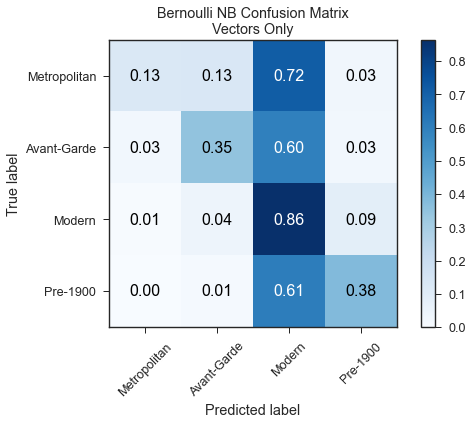

In [47]:
# plot confusion matrix - normalized
cm = confusion_matrix(y_test, y_test_preds_bnb_vec)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']
plot_confusion_matrix(cm, classes, normalize=True,
                      title='Bernoulli NB Confusion Matrix\nVectors Only', cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/bnb_vec_cm.png', transparent=True, bbox_inches='tight', dpi=100)

### Vectors + numerical data

In [48]:
%%time

# instantiate the naive bayes classifier
benaba_combo = BernoulliNB()

# fit it to our training set
benaba_combo.fit(X_train_combo, y_train)

CPU times: user 13.1 s, sys: 3.33 s, total: 16.4 s
Wall time: 16.3 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [49]:
%%time

# predict the new document from the testing dataset
y_train_preds_bnb_combo = benaba_combo.predict(X_train_combo)
y_test_preds_bnb_combo = benaba_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
benaba_combo_acc_train = accuracy_score(y_train, y_train_preds_bnb_combo)
benaba_combo_f1_train = f1_score(y_train, y_train_preds_bnb_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {benaba_combo_acc_train}')
print(f'F1 score: {benaba_combo_f1_train}')

# print out accuracy and f1 scores for test set
benaba_combo_acc_test = accuracy_score(y_test, y_test_preds_bnb_combo)
benaba_combo_f1_test = f1_score(y_test, y_test_preds_bnb_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {benaba_combo_acc_test}')
print(f'F1 score: {benaba_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_bnb_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_bnb_combo))

-----TRAIN-----
Accuracy: 0.6684210526315789
F1 score: 0.6751999282476966

-----TEST-----
Accuracy: 0.4586815227483751
F1 score: 0.4296462820371316

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.74      0.13      0.22       239
 avant_garde       0.66      0.35      0.46       268
      modern       0.36      0.86      0.51       311
    pre_1900       0.71      0.38      0.50       259

    accuracy                           0.46      1077
   macro avg       0.62      0.43      0.42      1077
weighted avg       0.60      0.46      0.43      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[ 31  32 169   7]
 [  9  95 158   6]
 [  2  13 269  27]
 [  0   3 157  99]]
CPU times: user 17.1 s, sys: 3.06 s, total: 20.2 s
Wall time: 19.9 s


- Practically the same result; a very slight boost if anything.

#### Confusion matrix

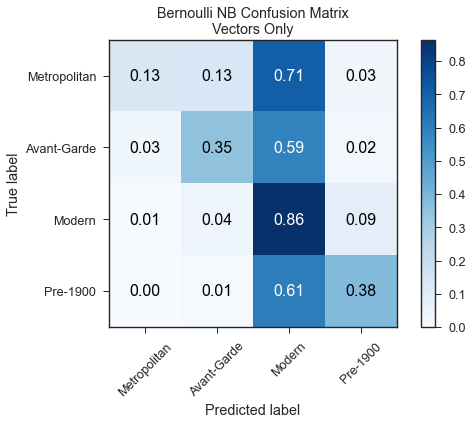

In [50]:
# plot confusion matrix - normalized
cm = confusion_matrix(y_test, y_test_preds_bnb_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']
plot_confusion_matrix(cm, classes, normalize=True,
                      title='Bernoulli NB Confusion Matrix\nVectors Only', cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/bnb_combo_cm.png', transparent=True, bbox_inches='tight', dpi=100)

- This confirms it is practically the same, with a slightly better accuracy at predicting Metropolitan.

#### Feature importances

In [51]:
# function to print top 10 features for each class
print_nb_features(
            benaba_combo,
            X_train_combo,
            ['metropolitan', 'avant_garde', 'modern', 'pre_1900']
        )

Metropolitan tweets:
zz, slackend, impending, impend, impels, slackened, impediment, impedes, slackening, impede

Avant-Garde tweets:
lengthwise, modestly, modernest, moderately, moderate, modelled, mod, mocks, mockingbirds, mockingbird

Modern tweets:
lengthwise, hazel, hazed, hazards, scraping, hazarded, scrappy, hazan, hayworth, haystraw

Pre-1900 tweets:
lengthwise, milkpitcher, milkman, milker, militarisme, militant, milieus, milieu, miliar, milholland



- Interestingly, these are still all word vectors, but different from the vectors-only model.

## K-Nearest Neighbors

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors only model and a combo model.

⏰ NOTE: The next cell took me about three minutes to run.

In [52]:
%%time

# instantiate decision tree classifiers
knn_vec = KNeighborsClassifier()
knn_combo = KNeighborsClassifier()

# fit them to the training set and evaluate
cv_scores_knn_vec = cross_val_score(
    knn_vec, X_train_vec, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_knn_combo = cross_val_score(
    knn_combo, X_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_knn_vec}')
print(f'Average score: {np.mean(cv_scores_knn_vec)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_knn_combo}')
print(f'Average score: {np.mean(cv_scores_knn_combo)}\n')

-----Vectors only-----
All scores: [0.34081473 0.32791069 0.37598843 0.33418527 0.32975972 0.32500524
 0.31292064 0.36944109 0.35442761 0.33124332]
Average score: 0.3401696752712211

------Vectors + Numerical Data-----
All scores: [0.50270974 0.52729918 0.55621674 0.56323718 0.53661691 0.48830611
 0.53023397 0.55724183 0.55134632 0.53379778]
Average score: 0.5347005761956732

CPU times: user 5min 47s, sys: 18.2 s, total: 6min 5s
Wall time: 14min 56s


- This performs better than the Naive Bayes model, and the combo data set is far better than vectors only.
- First, I'll try to find the best value for *k*, then train a model.

### Vectors + numerical data

⏰ NOTE: The next cell took me over 40 minutes to run.

100%|██████████| 25/25 [42:39<00:00, 102.38s/it]


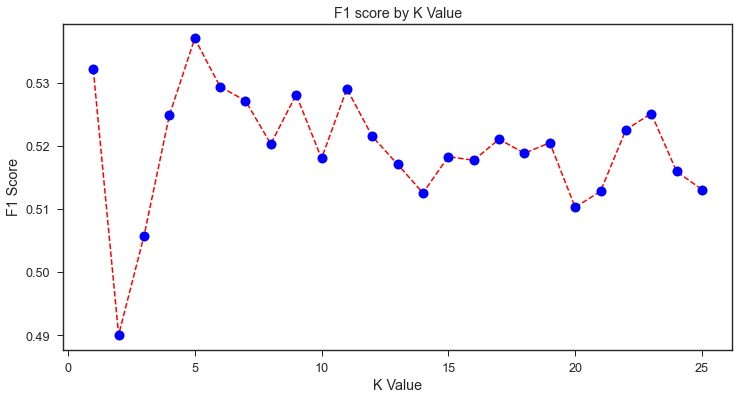

CPU times: user 3h 35min 38s, sys: 2min 38s, total: 3h 38min 16s
Wall time: 42min 39s


In [53]:
%%time

# create a container to track the scores
k_scores = []

# set up a loop to fit the model using a different values of k
k_range = list(range(1, 26))
for k in tqdm(k_range):
    
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    # fit the model and get the score on an evaluation metric
    knn.fit(X_train_combo, y_train)
    y_pred = knn.predict(X_test_combo)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # add to container
    k_scores.append(f1)
    
# plot a graph
plt.figure(figsize=(12, 6))  
plt.plot(k_range, k_scores, color='red', linestyle='dashed', 
         marker='o', markerfacecolor='blue', markersize=10)
plt.title('F1 score by K Value')  
plt.xlabel('K Value')  
plt.ylabel('F1 Score') 
plt.show()

In [54]:
# five highest scores
sorted_scores = sorted(list(enumerate(k_scores, 1)), 
                       key=lambda tup: tup[1], 
                       reverse=True)
sorted_scores[:5]

[(5, 0.537095723460491),
 (1, 0.5321888160863517),
 (6, 0.5294555875763667),
 (11, 0.5291090099029194),
 (9, 0.5281936024573077)]

- *k=5* appears to have the best results, so I'll train a model on that.

In [56]:
%%time

# instantiate the model
knn_combo = KNeighborsClassifier(
    n_neighbors=5, 
    n_jobs=-1)

# fit to the training set
knn_combo.fit(X_train_combo, y_train)

CPU times: user 19.1 s, sys: 3.69 s, total: 22.8 s
Wall time: 23.3 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

⏰ NOTE: The next cell took me about 6 minutes to run.

In [57]:
%%time

# predict class for the train and test sets
y_train_preds_knn_combo = knn_combo.predict(X_train_combo)
y_test_preds_knn_combo = knn_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
knn_combo_acc_train = accuracy_score(y_train, y_train_preds_knn_combo)
knn_combo_f1_train = f1_score(y_train, y_train_preds_knn_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {knn_combo_acc_train}')
print(f'F1 score: {knn_combo_f1_train}')

# print out accuracy and f1 scores for test set
knn_combo_acc_test = accuracy_score(y_test, y_test_preds_knn_combo)
knn_combo_f1_test = f1_score(y_test, y_test_preds_knn_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {knn_combo_acc_test}')
print(f'F1 score: {knn_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_knn_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_knn_combo))

-----TRAIN-----
Accuracy: 0.7018575851393188
F1 score: 0.6998579791649526

-----TEST-----
Accuracy: 0.542246982358403
F1 score: 0.537095723460491

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.48      0.64      0.55       239
 avant_garde       0.48      0.49      0.49       268
      modern       0.52      0.38      0.44       311
    pre_1900       0.68      0.71      0.70       259

    accuracy                           0.54      1077
   macro avg       0.54      0.55      0.54      1077
weighted avg       0.54      0.54      0.54      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[152  51  26  10]
 [ 82 131  40  15]
 [ 64  70 117  60]
 [ 16  19  40 184]]
CPU times: user 35min 31s, sys: 18 s, total: 35min 49s
Wall time: 5min 51s


#### Confusion matrix

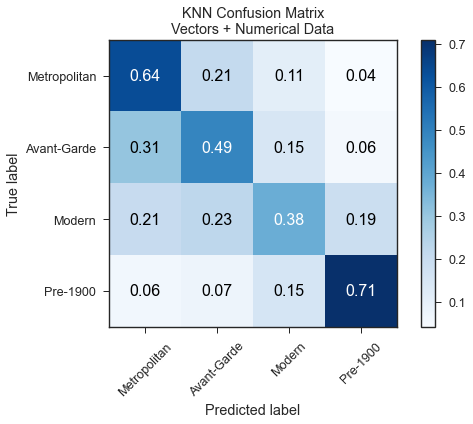

In [58]:
# plot confusion matrix - normalized
cm = confusion_matrix(y_test, y_test_preds_knn_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']
plot_confusion_matrix(cm, classes, normalize=True,
                      title='KNN Confusion Matrix\nVectors + Numerical Data', cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/knn_combo_cm.png', transparent=True, bbox_inches='tight', dpi=100)

- This is definitely better than the Naive Bayes model.
    - It predicts Modern a lot less. If anything, it has perhaps gone too far in the other direction.
    - Much better at predicting Metropolitan, which is interesting. Perhaps this genre is quite clustered.
    - Predictions seem fairly evenly spread.
    - Has trouble correctly predicting Modern and Avant-Garde.
    
- Pretty overfit.

## Decision Tree

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors only model and a combo model.

⏰ NOTE: The next cell took me about 7 minutes to run.

In [59]:
%%time

# instantiate decision tree classifiers
tree_vec = DecisionTreeClassifier()
tree_combo = DecisionTreeClassifier()

# fit them to the training set and evaluate
cv_scores_tree_vec = cross_val_score(
    tree_vec, X_train_vec, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_tree_combo = cross_val_score(
    tree_combo, X_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_tree_vec}')
print(f'Average score: {np.mean(cv_scores_tree_vec)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_tree_combo}')
print(f'Average score: {np.mean(cv_scores_tree_combo)}\n')

-----Vectors only-----
All scores: [0.39056505 0.4423269  0.44208162 0.38980819 0.3919311  0.33070953
 0.3769726  0.40805854 0.4269511  0.39680393]
Average score: 0.3996208559190092

------Vectors + Numerical Data-----
All scores: [0.41183688 0.45405351 0.45322565 0.48149612 0.49517766 0.47624228
 0.52851822 0.48355981 0.52651536 0.4723851 ]
Average score: 0.47830106009324896

CPU times: user 5min 21s, sys: 6.67 s, total: 5min 27s
Wall time: 7min 16s


- A Decision Tree isn't shaping up to be a very good model; it is not much better than Naive Bayes and definitely worse than KNN.
- I'll keep it in mind if I need to check out feature importances, since KNN doesn't provide that information. I should be able to obtain those using Random Forest, however.

## Random Forest

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors-only model and a combo model.

⏰ NOTE: The next cell took me about 9 minutes to run.

In [61]:
%%time

# instantiate random forest classifiers
forest_vec = RandomForestClassifier()
forest_combo = RandomForestClassifier()

# fit them to the training set and evaluate
cv_scores_forest_vec = cross_val_score(
    forest_vec, X_train_vec, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_forest_combo = cross_val_score(
    forest_combo, X_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_forest_vec}')
print(f'Average score: {np.mean(cv_scores_forest_vec)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_forest_combo}')
print(f'Average score: {np.mean(cv_scores_forest_combo)}\n')

-----Vectors only-----
All scores: [0.5100105  0.55923077 0.5780584  0.57351395 0.58257986 0.48371832
 0.52496157 0.56194346 0.5987772  0.53413129]
Average score: 0.5506925316619518

------Vectors + Numerical Data-----
All scores: [0.57420367 0.60224989 0.59755879 0.61823796 0.61399907 0.538425
 0.588945   0.58622197 0.61030985 0.59378793]
Average score: 0.5923939110709662

CPU times: user 6min 5s, sys: 6.89 s, total: 6min 12s
Wall time: 8min 43s


- Including engineered features seems more promising, so I'll move ahead with this one.

### Vectors + numerical data

In [62]:
%%time

# instantiate the model
forest_combo = RandomForestClassifier(random_state=1)

# fit to the training set
forest_combo.fit(X_train_combo, y_train)

CPU times: user 20.6 s, sys: 1.51 s, total: 22.1 s
Wall time: 22.1 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [63]:
%%time

# predict class for the train and test sets
y_train_preds_forest_combo = forest_combo.predict(X_train_combo)
y_test_preds_forest_combo = forest_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
forest_combo_acc_train = accuracy_score(y_train, y_train_preds_forest_combo)
forest_combo_f1_train = f1_score(y_train, y_train_preds_forest_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {forest_combo_acc_train}')
print(f'F1 score: {forest_combo_f1_train}')

# print out accuracy and f1 scores for test set
forest_combo_acc_test = accuracy_score(y_test, y_test_preds_forest_combo)
forest_combo_f1_test = f1_score(y_test, y_test_preds_forest_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {forest_combo_acc_test}')
print(f'F1 score: {forest_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_forest_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_forest_combo))

-----TRAIN-----
Accuracy: 1.0
F1 score: 1.0

-----TEST-----
Accuracy: 0.5933147632311978
F1 score: 0.592403359522887

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.57      0.47      0.52       239
 avant_garde       0.57      0.47      0.51       268
      modern       0.50      0.67      0.57       311
    pre_1900       0.79      0.74      0.77       259

    accuracy                           0.59      1077
   macro avg       0.61      0.59      0.59      1077
weighted avg       0.60      0.59      0.59      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[113  53  68   5]
 [ 48 125  85  10]
 [ 36  31 209  35]
 [  2   9  56 192]]
CPU times: user 9.46 s, sys: 1.92 s, total: 11.4 s
Wall time: 11.4 s


#### Confusion matrix

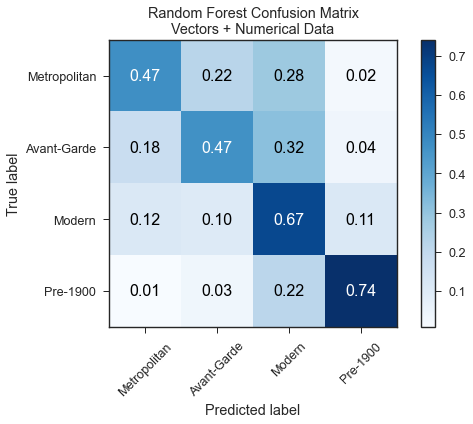

In [64]:
# plot confusion matrix - normalized
cm = confusion_matrix(y_test, y_test_preds_forest_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']
plot_confusion_matrix(
    cm, 
    classes, 
    normalize=True,
    title='Random Forest Confusion Matrix\nVectors + Numerical Data', 
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/rf_combo_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

- Much better overall F1 score, but I'm back to overpredicting Modern.
- Unlike KNN, however, this is very overfit, so tuning this would definitely be necessary.
- Still, this will be a great model to use to look at important features.

#### Feature importances

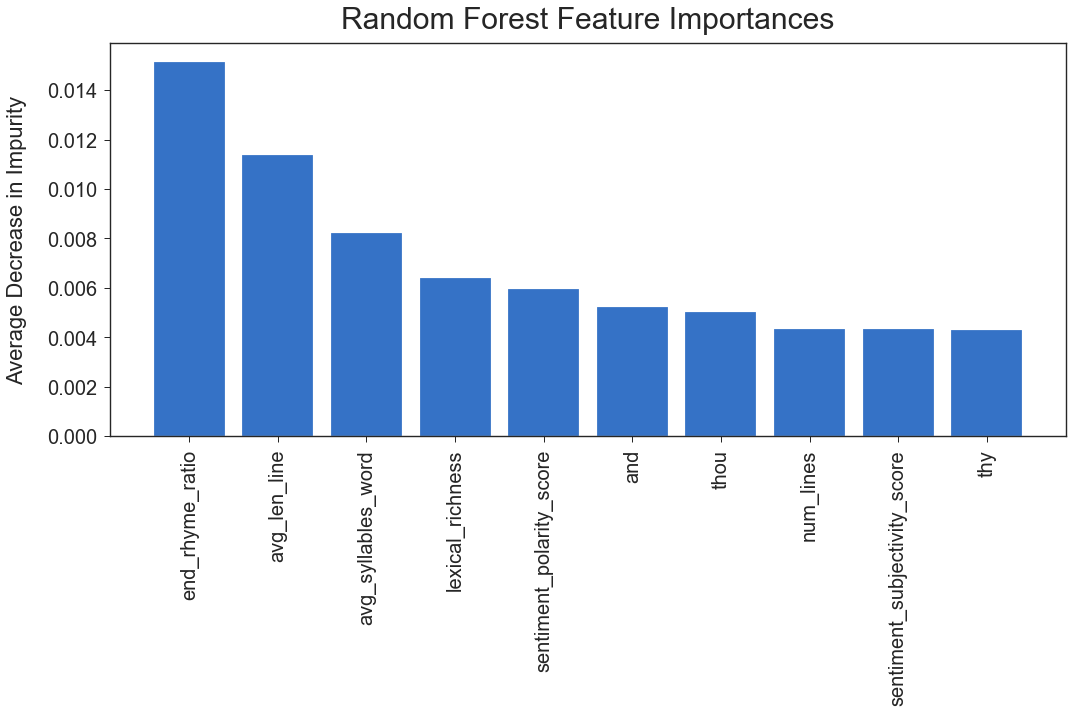





[('end_rhyme_ratio', 0.01513269871718084), ('avg_len_line', 0.011356006587025416), ('avg_syllables_word', 0.008207915476957758), ('lexical_richness', 0.0063850099869278525), ('sentiment_polarity_score', 0.005968426331171708), ('and', 0.005212066615805195), ('thou', 0.0050384785067620706), ('num_lines', 0.004322734479828278), ('sentiment_subjectivity_score', 0.004322129583883042), ('thy', 0.004285908048344382)]


In [65]:
# top 10 features
plot_forest_features(
    forest_combo, 
    X_train_combo)

- Mostly engineered features here, with the ratio of end rhymes to total lines have a large importance compared to the rest.
- Also, some interesting words.
    - *And* is a bit of a mystery as AH SHIT.
    - *Heart* only appears in the top 25 words for Pre-1900 poetry.
    - *Love* is the second most used word (after processing), and appears in the top 25 of all classes.

## SVM

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors only model and a combo model.

⏰ NOTE: Next cell took me 10 minutes to run.

In [66]:
%%time

# instantiate svm classifiers
svm_vec = LinearSVC()
svm_combo = LinearSVC()

# fit them to the training set and evaluate
cv_scores_svm_vec = cross_val_score(
    svm_vec, X_train_vec, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_svm_combo = cross_val_score(
    svm_combo, X_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_svm_vec}')
print(f'Average score: {np.mean(cv_scores_svm_vec)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_svm_combo}')
print(f'Average score: {np.mean(cv_scores_svm_combo)}\n')

-----Vectors only-----
All scores: [0.62761568 0.71386136 0.59946969 0.64340131 0.65450934 0.66156892
 0.58829792 0.61299607 0.65410261 0.60955467]
Average score: 0.636537757851741

------Vectors + Numerical Data-----
All scores: [0.65097901 0.70820609 0.64683284 0.68607899 0.65457732 0.67129181
 0.66054012 0.67212663 0.72090737 0.63698163]
Average score: 0.6708521793164735

CPU times: user 5min 44s, sys: 10.4 s, total: 5min 54s
Wall time: 10min 9s


- This is the best one yet! And I'm not surprised. SVM tends to work well with text classification and data that has fewer data points and lots of variables (i.e. word vectors).
- Once again, my engineered features seem to help out the model, so I'll train a basic one here. Then I can focus on tuning parameters.

### Vectors + numerical data

In [67]:
%%time

# instantiate the model
svm_combo = LinearSVC(random_state=1)

# fit to the training set
svm_combo.fit(X_train_combo, y_train)

CPU times: user 41.7 s, sys: 2.25 s, total: 43.9 s
Wall time: 44 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [68]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo = svm_combo.predict(X_train_combo)
y_test_preds_svm_combo = svm_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train = accuracy_score(y_train, y_train_preds_svm_combo)
svm_combo_f1_train = f1_score(y_train, y_train_preds_svm_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train}')
print(f'F1 score: {svm_combo_f1_train}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test = accuracy_score(y_test, y_test_preds_svm_combo)
svm_combo_f1_test = f1_score(y_test, y_test_preds_svm_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test}')
print(f'F1 score: {svm_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo))

-----TRAIN-----
Accuracy: 0.9990712074303405
F1 score: 0.9990713532528626

-----TEST-----
Accuracy: 0.6564531104921077
F1 score: 0.6552542692291389

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.60      0.65      0.62       239
 avant_garde       0.60      0.60      0.60       268
      modern       0.61      0.56      0.59       311
    pre_1900       0.81      0.84      0.83       259

    accuracy                           0.66      1077
   macro avg       0.66      0.66      0.66      1077
weighted avg       0.66      0.66      0.66      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[155  43  34   7]
 [ 50 160  50   8]
 [ 47  54 175  35]
 [  5  11  26 217]]
CPU times: user 11 s, sys: 2.36 s, total: 13.4 s
Wall time: 12.4 s


#### Confusion matrix

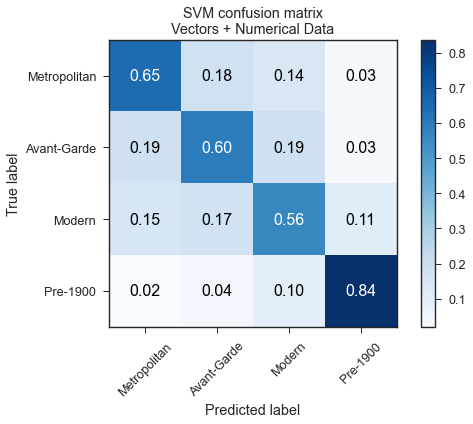

In [70]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, y_test_preds_svm_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, 
    classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/svm_combo_untuned_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

- Still overfit but a very good spread of predictions here compared to the other models.
    - Each category is correctly predicted at least half the time.
- Pre-1900 poetry is very easily recognized by the model.
    - Modern poetry appears to be the largest confusing factor here, so must share some similarities. 
    - Avant-Garde and Metropolitan are hardly ever predicted for Pre-1900 poems and Pre-1900 is hardly predicted for Metropolitan and Avant-Garde poems.
- As in the KNN, Metropolitan has seen quite a boost, whereas Avant-Garde and Modern seem a little more difficult to correctly predict.

#### Feature importances

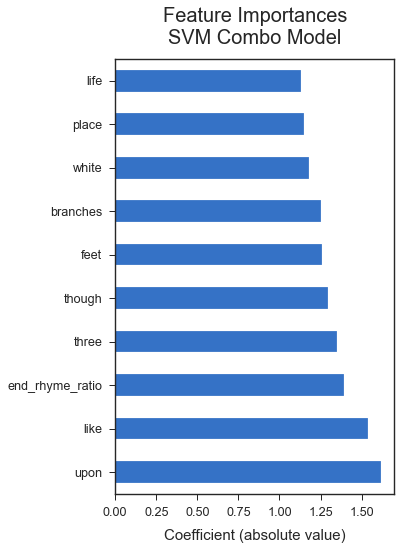

In [71]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_combo.coef_[0]), 
              index=X_train_combo.columns).nlargest(10).\
              plot(kind='barh');

- Only the ratio of end rhymes to total lines made it from my engineered features. 
- Mostly surprising words, *white* being the only word in the top 25 overall.

## Parameter tuning

[[go back to the top](#Predicting-Poetic-Movements)]

#### Finding the best value for *C* using GridSearchCV.

In [73]:
param_grid = {
    'C': [0.1, 0.5, 1, 1.5, 2]
}

In [74]:
svm_grid = GridSearchCV(LinearSVC(random_state=1), 
                        param_grid, 
                        scoring='f1_weighted', 
                        cv=5, n_jobs=-1, verbose=2)

In [75]:
svm_grid.fit(X_train_combo, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed: 11.1min remaining:   58.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 11.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=1, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 1.5, 2]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='f1_weighted',
             verbose=2)

In [76]:
# examine the best model
print(svm_grid.best_score_)
print(svm_grid.best_params_)
print(svm_grid.best_estimator_)

0.6686173647100484
{'C': 1}
LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)


## Doc2Vec

[[go back to the top](#Predicting-Poetic-Movements)]

In [44]:
train_data = [poem.split() for poem in X_train.string_processed]
test_data = [poem.split() for poem in X_test.string_processed]

In [96]:
%%time

# prepare training data in doc2vec format
train_docs = [TaggedDocument((d), tags=[str(i)]) for i, d in enumerate(train_data)]

# train a doc2vec model to learn tweet representations. Use only training data!!
model = Doc2Vec(vector_size=100, alpha=0.025, min_count=5, dm=1, epochs=100)
model.build_vocab(train_docs)
model.train(train_docs, total_examples=model.corpus_count, epochs=model.epochs)
model.save('data/d2v.model')
print("Model Saved")

Model Saved
CPU times: user 2min 11s, sys: 3.77 s, total: 2min 15s
Wall time: 1min 1s


In [97]:
%%time

model = Doc2Vec.load('data/d2v.model')

# infer in multiple steps to get a stable representation. 
train_vecs = [model.infer_vector(words, epochs=100) for words in train_data]
test_vecs = [model.infer_vector(words, epochs=100) for words in test_data]

CPU times: user 2min 10s, sys: 604 ms, total: 2min 11s
Wall time: 2min 11s


In [80]:
# %%time

# # prepare training data in doc2vec format
# train_docs = [TaggedDocument((d), tags=[str(i)]) for i, d in enumerate(train_data)]

# # train a doc2vec model to learn tweet representations. Use only training data!!
# model = Doc2Vec(vector_size=50, alpha=0.025, min_count=5, dm=1, epochs=100)
# model.build_vocab(train_docs)
# model.train(train_docs, total_examples=model.corpus_count, epochs=model.epochs)
# model.save('data/d2v.model')
# print("Model Saved")

Model Saved
CPU times: user 2min 11s, sys: 3.6 s, total: 2min 14s
Wall time: 1min


In [81]:
# %%time

# model = Doc2Vec.load('data/d2v.model')

# # infer in multiple steps to get a stable representation. 
# train_vecs = [model.infer_vector(words, epochs=100) for words in train_data]
# test_vecs = [model.infer_vector(words, epochs=100) for words in test_data]

CPU times: user 1min 56s, sys: 345 ms, total: 1min 57s
Wall time: 1min 57s


In [151]:
doc_train_vecs.loc[:,0].describe()

count    3230.000000
mean        0.992904
std         1.761595
min        -6.663454
25%        -0.101686
50%         0.954989
75%         2.100768
max         8.666050
Name: 0, dtype: float64

In [98]:
doc_train_vecs = pd.DataFrame(train_vecs)
doc_test_vecs = pd.DataFrame(test_vecs)
doc_train_combo = pd.concat([X_train_scaled_df, doc_train_vecs], axis=1)
doc_test_combo = pd.concat([X_test_scaled_df, doc_test_vecs], axis=1)

In [167]:
X_trained = X_train.drop(columns='string_processed').reset_index(drop=True)
X_tested = X_test.drop(columns='string_processed').reset_index(drop=True)
X_trained.head()

,num_lines,avg_len_line,sentiment_polarity_score,sentiment_subjectivity_score,end_rhyme_ratio,avg_syllables_word,lexical_richness
0,8.0,6.625000,-0.8316,0.593750,0.375000,1.169811,0.754717
1,120.0,8.308333,0.9902,0.404139,0.083333,1.251755,0.494483
2,14.0,7.857143,-0.9325,0.298765,0.142857,1.218182,0.754545
3,131.7,5.613793,0.9965,0.507405,0.910345,1.179361,0.552826
4,7.0,6.000000,-0.0772,0.490476,0.000000,1.250000,0.850402


In [173]:
# instantiate scaler
scaler = StandardScaler()

# scale numerical data
X_train_scaled = scaler.fit_transform(X_train_nums)
X_test_scaled = scaler.transform(X_test_nums)

# turn the arrays into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_nums.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_nums.columns)

In [180]:
doc_train_vecs = pd.DataFrame(train_vecs, columns=[f'docvec_{i}' for i in range(100)])
doc_test_vecs = pd.DataFrame(test_vecs, columns=[f'docvec_{i}' for i in range(100)])
doc_train_combo = pd.concat([X_train_scaled_df, doc_train_vecs], axis=1)
doc_test_combo = pd.concat([X_test_scaled_df, doc_test_vecs], axis=1)

In [126]:
# # instantiate scaler
# scaler = MinMaxScaler()

# # scale numerical data
# doc_train_scaled = scaler.fit_transform(doc_train_vecs)
# doc_test_scaled = scaler.transform(doc_test_vecs)

# # turn the arrays into dataframes
# doc_train_scaled_df = pd.DataFrame(doc_train_scaled, columns=[f'{i}_doc' for i in range(100)])
# doc_test_scaled_df = pd.DataFrame(doc_test_scaled, columns=[f'{i}_doc' for i in range(100)])

In [128]:
# doc_train_combo = pd.concat([X_train_scaled_df, doc_train_scaled_df], axis=1)
# doc_test_combo = pd.concat([X_test_scaled_df, doc_test_scaled_df], axis=1)

In [181]:
%%time

# instantiate the model
svm_doc = LinearSVC(C=1, random_state=1)

# fit to the training set
svm_doc.fit(doc_train_combo, y_train)

CPU times: user 3.01 s, sys: 14.2 ms, total: 3.02 s
Wall time: 3.03 s


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [182]:
%%time

# predict class for the train and test sets
train_doc_preds = svm_doc.predict(doc_train_combo)
test_doc_preds = svm_doc.predict(doc_test_combo)

# print out accuracy and f1 scores for train set
svm_doc_acc_train = accuracy_score(y_train, train_doc_preds)
svm_doc_f1_train = f1_score(y_train, train_doc_preds, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_doc_acc_train}')
print(f'F1 score: {svm_doc_f1_train}')

# print out accuracy and f1 scores for test set
svm_doc_acc_test = accuracy_score(y_test, test_doc_preds)
svm_doc_f1_test = f1_score(y_test, test_doc_preds, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_doc_acc_test}')
print(f'F1 score: {svm_doc_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, test_doc_preds, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, test_doc_preds))

-----TRAIN-----
Accuracy: 0.6448916408668731
F1 score: 0.6392743560964644

-----TEST-----
Accuracy: 0.6230269266480966
F1 score: 0.6151378424987388

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.58      0.52      0.55       239
 avant_garde       0.51      0.66      0.57       268
      modern       0.63      0.43      0.51       311
    pre_1900       0.79      0.91      0.84       259

    accuracy                           0.62      1077
   macro avg       0.62      0.63      0.62      1077
weighted avg       0.62      0.62      0.62      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[125  77  31   6]
 [ 48 176  37   7]
 [ 40  85 135  51]
 [  3   9  12 235]]
CPU times: user 230 ms, sys: 42 ms, total: 272 ms
Wall time: 72.5 ms


In [100]:
%%time

# predict class for the train and test sets
train_doc_preds = svm_doc.predict(doc_train_combo)
test_doc_preds = svm_doc.predict(doc_test_combo)

# print out accuracy and f1 scores for train set
svm_doc_acc_train = accuracy_score(y_train, train_doc_preds)
svm_doc_f1_train = f1_score(y_train, train_doc_preds, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_doc_acc_train}')
print(f'F1 score: {svm_doc_f1_train}')

# print out accuracy and f1 scores for test set
svm_doc_acc_test = accuracy_score(y_test, test_doc_preds)
svm_doc_f1_test = f1_score(y_test, test_doc_preds, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_doc_acc_test}')
print(f'F1 score: {svm_doc_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, test_doc_preds, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, test_doc_preds))

-----TRAIN-----
Accuracy: 0.6585139318885449
F1 score: 0.6560742808616792

-----TEST-----
Accuracy: 0.606313834726091
F1 score: 0.5956090187065598

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.60      0.46      0.52       239
 avant_garde       0.48      0.72      0.57       268
      modern       0.64      0.39      0.49       311
    pre_1900       0.77      0.88      0.82       259

    accuracy                           0.61      1077
   macro avg       0.62      0.61      0.60      1077
weighted avg       0.62      0.61      0.60      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[109  98  24   8]
 [ 39 194  27   8]
 [ 33 104 122  52]
 [  1  11  19 228]]
CPU times: user 240 ms, sys: 39.2 ms, total: 280 ms
Wall time: 72.7 ms


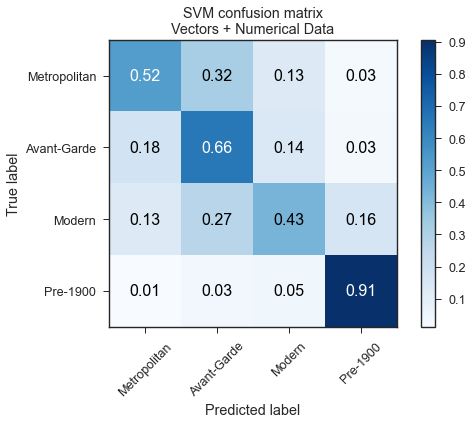

In [183]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_doc_preds)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/svm_doc_untuned_cm.png', transparent=True, 
#             bbox_inches='tight', dpi=100)

## Parameter tuning

[[go back to the top](#Predicting-Poetic-Movements)]

#### Finding the best value for *C* using GridSearchCV.

In [132]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

In [133]:
doc_grid = GridSearchCV(LinearSVC(random_state=1), 
                        param_grid, 
                        scoring='f1_weighted', 
                        cv=10, n_jobs=-1, verbose=2)

In [134]:
doc_grid.fit(doc_train_combo, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   20.4s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=1, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=2)

In [135]:
# examine the best model
print(doc_grid.best_score_)
print(doc_grid.best_params_)
print(doc_grid.best_estimator_)

0.6257452409264448
{'C': 0.1}
LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)


In [136]:
param_grid = {
    'C': [0.025, 0.05, 0.075, 0.1, 0.25, 0.5]
}

In [137]:
doc_grid = GridSearchCV(LinearSVC(random_state=1), 
                        param_grid, 
                        scoring='f1_weighted', 
                        cv=10, n_jobs=-1, verbose=2)

In [138]:
doc_grid.fit(doc_train_combo, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.6s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=1, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.025, 0.05, 0.075, 0.1, 0.25, 0.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=2)

In [139]:
# examine the best model
print(doc_grid.best_score_)
print(doc_grid.best_params_)
print(doc_grid.best_estimator_)

0.6257452409264448
{'C': 0.1}
LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)


In [140]:
%%time

# instantiate the model
svm_doc = LinearSVC(C=0.1, random_state=1)

# fit to the training set
svm_doc.fit(doc_train_combo, y_train)

CPU times: user 288 ms, sys: 1.99 ms, total: 290 ms
Wall time: 290 ms


LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [141]:
%%time

# predict class for the train and test sets
train_doc_preds = svm_doc.predict(doc_train_combo)
test_doc_preds = svm_doc.predict(doc_test_combo)

# print out accuracy and f1 scores for train set
svm_doc_acc_train = accuracy_score(y_train, train_doc_preds)
svm_doc_f1_train = f1_score(y_train, train_doc_preds, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_doc_acc_train}')
print(f'F1 score: {svm_doc_f1_train}')

# print out accuracy and f1 scores for test set
svm_doc_acc_test = accuracy_score(y_test, test_doc_preds)
svm_doc_f1_test = f1_score(y_test, test_doc_preds, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_doc_acc_test}')
print(f'F1 score: {svm_doc_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, test_doc_preds, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, test_doc_preds))

-----TRAIN-----
Accuracy: 0.6684210526315789
F1 score: 0.6649860975615821

-----TEST-----
Accuracy: 0.6313834726090993
F1 score: 0.6230025635996339

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.61      0.51      0.55       239
 avant_garde       0.52      0.72      0.60       268
      modern       0.64      0.44      0.52       311
    pre_1900       0.79      0.89      0.84       259

    accuracy                           0.63      1077
   macro avg       0.64      0.64      0.63      1077
weighted avg       0.64      0.63      0.62      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[121  85  29   4]
 [ 38 192  30   8]
 [ 37  87 136  51]
 [  3   8  17 231]]
CPU times: user 234 ms, sys: 32.6 ms, total: 267 ms
Wall time: 67.9 ms


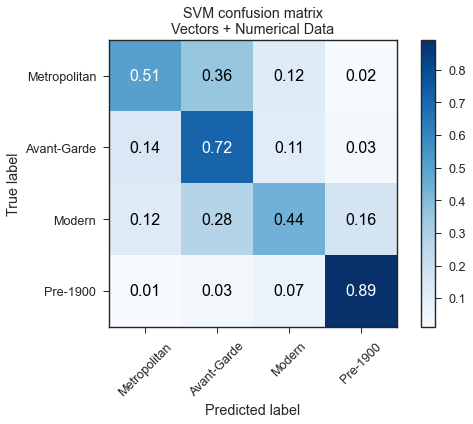

In [142]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_doc_preds)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/svm_doc_untuned_cm.png', transparent=True, 
#             bbox_inches='tight', dpi=100)

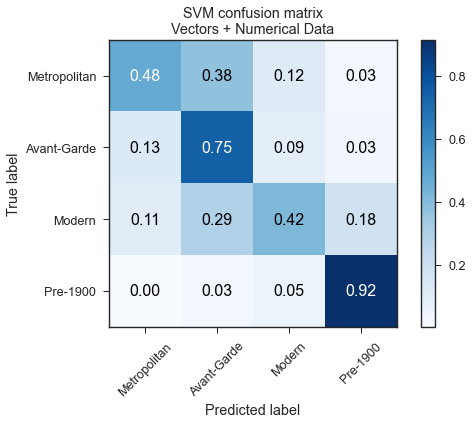

In [112]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_doc_preds)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/svm_doc_untuned_cm.png', transparent=True, 
#             bbox_inches='tight', dpi=100)

## Word2Vec

In [113]:
import os
from gensim.models import Word2Vec, KeyedVectors

In [114]:
%%time

path_to_model = os.path.expanduser('~/Documents/word_embeddings/glove6b/glove.6B.100d.w2vformat.txt')
w2v_model = KeyedVectors.load_word2vec_format(path_to_model)

CPU times: user 32.6 s, sys: 352 ms, total: 33 s
Wall time: 33 s


In [115]:
%%time

# Inspect the model
word2vec_vocab = w2v_model.vocab.keys()
word2vec_vocab_lower = [item.lower() for item in word2vec_vocab]
print(len(word2vec_vocab))

400000
CPU times: user 49.6 ms, sys: 9.29 ms, total: 58.9 ms
Wall time: 59 ms


In [116]:
# Creating a feature vector by averaging all embeddings for all sentences
def embedding_feats(list_of_lists):
    DIMENSION = 100
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0
        for token in tokens:
            if token in w2v_model:
                feat_for_this += w2v_model[token]
                count_for_this +=1
        feats.append(feat_for_this/count_for_this)        
    return feats


train_vectors = embedding_feats(train_data)
test_vectors = embedding_feats(test_data)
print(len(train_vectors), len(test_vectors))

3230 1077


In [117]:
word_train_vecs = pd.DataFrame(train_vectors)
word_test_vecs = pd.DataFrame(test_vectors)
word_train_combo = pd.concat([X_train_scaled_df, word_train_vecs], axis=1)
word_test_combo = pd.concat([X_test_scaled_df, word_test_vecs], axis=1)

In [143]:
word_train_vecs.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.063965,0.396729,0.362696,-0.277709,0.092109,0.396394,-0.144798,0.031038,-0.019494,-0.110360,...,-0.030708,-0.082802,-0.053728,0.294321,-0.407026,-0.077790,-0.258677,-0.253838,0.397818,0.089002
1,-0.142037,0.156945,0.366548,-0.154507,0.089703,0.166874,-0.156685,0.245091,-0.307804,-0.046765,...,-0.032182,-0.120169,-0.255855,0.305469,-0.492269,-0.111947,-0.375512,-0.188994,0.536764,0.120501
2,-0.078680,0.240706,0.217747,-0.228748,-0.077332,0.296691,-0.161333,0.219881,-0.183728,0.005538,...,-0.048097,-0.246785,-0.129913,0.221735,-0.630081,-0.088870,-0.282409,-0.075479,0.420963,0.102228
3,-0.031505,0.207139,0.346954,-0.229655,-0.095215,0.280481,-0.220121,0.068330,-0.040607,0.031541,...,-0.059701,-0.133628,-0.038866,0.095527,-0.388108,-0.127672,-0.269131,-0.288725,0.325358,0.162469
4,-0.096264,0.262001,0.322441,-0.265170,-0.226717,0.243410,-0.237250,0.184360,-0.108633,-0.024488,...,-0.188620,-0.088395,-0.061890,0.186898,-0.525968,-0.102288,-0.304922,-0.379139,0.432350,0.287841


In [144]:
# instantiate scaler
scaler = MinMaxScaler()

# scale numerical data
word_train_scaled = scaler.fit_transform(word_train_vecs)
word_test_scaled = scaler.transform(word_test_vecs)

# turn the arrays into dataframes
word_train_scaled_df = pd.DataFrame(word_train_scaled, columns=[f'{i}_word' for i in range(100)])
word_test_scaled_df = pd.DataFrame(word_test_scaled, columns=[f'{i}_word' for i in range(100)])

In [145]:
ultra_train_combo = pd.concat([X_train_scaled_df, doc_train_scaled_df, word_train_scaled_df], axis=1)
ultra_test_combo = pd.concat([X_test_scaled_df, doc_test_scaled_df, word_test_scaled_df], axis=1)

In [118]:
%%time

# instantiate the model
svm_word = LinearSVC(C=1, random_state=1)

# fit to the training set
svm_word.fit(word_train_combo, y_train)

CPU times: user 1.68 s, sys: 5.31 ms, total: 1.69 s
Wall time: 1.69 s


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [119]:
%%time

# predict class for the train and test sets
train_word_preds = svm_word.predict(word_train_combo)
test_word_preds = svm_word.predict(word_test_combo)

# print out accuracy and f1 scores for train set
svm_word_acc_train = accuracy_score(y_train, train_word_preds)
svm_word_f1_train = f1_score(y_train, train_word_preds, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_word_acc_train}')
print(f'F1 score: {svm_word_f1_train}')

# print out accuracy and f1 scores for test set
svm_word_acc_test = accuracy_score(y_test, test_word_preds)
svm_word_f1_test = f1_score(y_test, test_word_preds, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_word_acc_test}')
print(f'F1 score: {svm_word_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, test_word_preds, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, test_word_preds))

-----TRAIN-----
Accuracy: 0.6365325077399381
F1 score: 0.6299622626907639

-----TEST-----
Accuracy: 0.5979572887650882
F1 score: 0.5910058491570886

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.59      0.67      0.62       239
 avant_garde       0.55      0.55      0.55       268
      modern       0.55      0.42      0.48       311
    pre_1900       0.69      0.79      0.74       259

    accuracy                           0.60      1077
   macro avg       0.59      0.61      0.60      1077
weighted avg       0.59      0.60      0.59      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[160  46  25   8]
 [ 61 148  45  14]
 [ 45  65 131  70]
 [  7   9  38 205]]
CPU times: user 222 ms, sys: 41 ms, total: 263 ms
Wall time: 69.9 ms


In [205]:
%%time

# predict class for the train and test sets
train_word_preds = svm_word.predict(word_train_combo)
test_word_preds = svm_word.predict(word_test_combo)

# print out accuracy and f1 scores for train set
svm_word_acc_train = accuracy_score(y_train, train_word_preds)
svm_word_f1_train = f1_score(y_train, train_word_preds, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_word_acc_train}')
print(f'F1 score: {svm_word_f1_train}')

# print out accuracy and f1 scores for test set
svm_word_acc_test = accuracy_score(y_test, test_word_preds)
svm_word_f1_test = f1_score(y_test, test_word_preds, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_word_acc_test}')
print(f'F1 score: {svm_word_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, test_word_preds, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, test_word_preds))

-----TRAIN-----
Accuracy: 0.6897832817337461
F1 score: 0.6860405703534922

-----TEST-----
Accuracy: 0.5988857938718662
F1 score: 0.590480461375245

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.59      0.62      0.60       239
 avant_garde       0.56      0.57      0.57       268
      modern       0.53      0.41      0.46       311
    pre_1900       0.70      0.84      0.76       259

    accuracy                           0.60      1077
   macro avg       0.59      0.61      0.60      1077
weighted avg       0.59      0.60      0.59      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[147  46  35  11]
 [ 53 154  50  11]
 [ 45  67 127  72]
 [  6  10  26 217]]
CPU times: user 234 ms, sys: 36.8 ms, total: 271 ms
Wall time: 70.8 ms


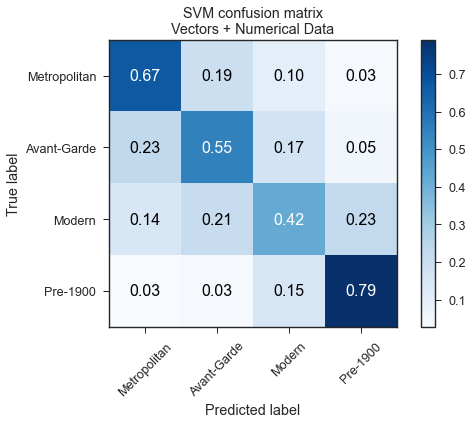

In [120]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_word_preds)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/svm_doc_untuned_cm.png', transparent=True, 
#             bbox_inches='tight', dpi=100)

In [184]:
ultra_train_combo = pd.concat([X_train_scaled_df, doc_train_vecs, word_train_vecs], axis=1)
ultra_test_combo = pd.concat([X_test_scaled_df, doc_test_vecs, word_test_vecs], axis=1)

In [185]:
%%time

# instantiate the model
svm_ultra = LinearSVC(C=1, random_state=1)

# fit to the training set
svm_ultra.fit(ultra_train_combo, y_train)

CPU times: user 4.99 s, sys: 11.2 ms, total: 5 s
Wall time: 5.01 s


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [186]:
%%time

# predict class for the train and test sets
train_ultra_preds = svm_ultra.predict(ultra_train_combo)
test_ultra_preds = svm_ultra.predict(ultra_test_combo)

# print out accuracy and f1 scores for train set
svm_ultra_acc_train = accuracy_score(y_train, train_ultra_preds)
svm_ultra_f1_train = f1_score(y_train, train_ultra_preds, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_ultra_acc_train}')
print(f'F1 score: {svm_ultra_f1_train}')

# print out accuracy and f1 scores for test set
svm_ultra_acc_test = accuracy_score(y_test, test_ultra_preds)
svm_ultra_f1_test = f1_score(y_test, test_ultra_preds, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_ultra_acc_test}')
print(f'F1 score: {svm_ultra_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, test_ultra_preds, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, test_ultra_preds))

-----TRAIN-----
Accuracy: 0.6947368421052632
F1 score: 0.6920764317173469

-----TEST-----
Accuracy: 0.6332404828226555
F1 score: 0.6265114136756625

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.62      0.56      0.59       239
 avant_garde       0.51      0.71      0.59       268
      modern       0.65      0.42      0.51       311
    pre_1900       0.80      0.87      0.83       259

    accuracy                           0.63      1077
   macro avg       0.64      0.64      0.63      1077
weighted avg       0.64      0.63      0.63      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[135  70  25   9]
 [ 42 191  28   7]
 [ 36 103 131  41]
 [  3  12  19 225]]
CPU times: user 203 ms, sys: 28.7 ms, total: 232 ms
Wall time: 59.2 ms


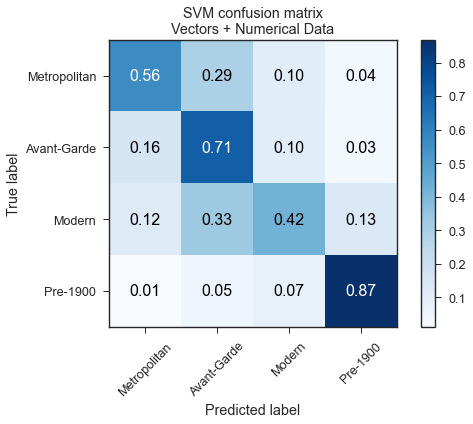

In [187]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_ultra_preds)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/svm_doc_untuned_cm.png', transparent=True, 
#             bbox_inches='tight', dpi=100)

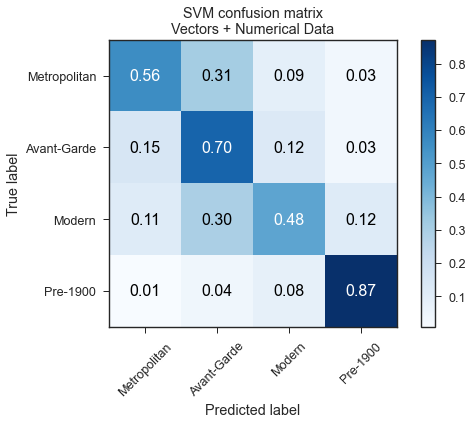

In [124]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, test_word_preds)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/svm_doc_untuned_cm.png', transparent=True, 
#             bbox_inches='tight', dpi=100)

## FastText

In [221]:
ft_train = pd.concat([X_train, y_train], axis=1)
ft_test = pd.concat([X_test, y_test], axis=1)

ft_train.shape, ft_test.shape

((3230, 9), (1077, 9))

In [222]:
# Write files to disk as fastText classifier API reads files from disk.
ft_train.to_csv('data/ft_train.csv', header=None, index=False, columns=ft_train.columns)

ft_test.to_csv('data/ft_test.csv', header=None, index=False, columns=ft_test.columns)

In [232]:
!gcc --version

gcc (GCC) 4.8.5
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [231]:
!pip install fasttext==0.9.2

  Using cached fasttext-0.9.2.tar.gz (68 kB)
  ERROR: Command errored out with exit status 1:
   command: /opt/anaconda3/envs/learn-env/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/3b/6q0d93qn66g5fg2t3938zdb40000gn/T/pip-install-201_o6t3/fasttext/setup.py'"'"'; __file__='"'"'/private/var/folders/3b/6q0d93qn66g5fg2t3938zdb40000gn/T/pip-install-201_o6t3/fasttext/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/3b/6q0d93qn66g5fg2t3938zdb40000gn/T/pip-wheel-ir63tbkt
       cwd: /private/var/folders/3b/6q0d93qn66g5fg2t3938zdb40000gn/T/pip-install-201_o6t3/fasttext/
  Complete output (58 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.7-x86_64-3.6
  creating build/lib.macosx-10.7-x86_64-3.6/fasttext
  copying python/fastte

In [225]:
from fasttext import train_supervised 

ModuleNotFoundError: No module named 'fastText'

In [ ]:

%%time
## Using fastText for feature extraction and training

"""fastText expects and training file (csv), a model name as input arguments.
label_prefix refers to the prefix before label string in the dataset.
default is __label__. In our dataset, it is __class__. 
There are several other parameters which can be seen in: 
https://pypi.org/project/fasttext/
"""
model = train_supervised(
    input=train_file, label="__class__", lr=1.0, 
    epoch=75, loss='ova', wordNgrams=2, dim=200, thread=2, verbose=100)

## Neural Nets

In [233]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model, Sequential
from keras.initializers import Constant

Using TensorFlow backend.


In [236]:
%%time

#Vectorize these text samples into a 2D integer tensor using Keras Tokenizer
#Tokenizer is fit on training data only, and that is used to tokenize both train and test data.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.string_processed)
train_sequences = tokenizer.texts_to_sequences(X_train.string_processed) #Converting text to a vector of word indexes
test_sequences = tokenizer.texts_to_sequences(X_test.string_processed)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 43072 unique tokens.
CPU times: user 994 ms, sys: 10.6 ms, total: 1 s
Wall time: 1.01 s


In [237]:
max([len(poem) for poem in train_data])

7609

In [240]:
le = LabelEncoder()
le_train = le.fit_transform(y_train)
le_test = le.transform(y_test)

In [241]:

#Converting this to sequences to be fed into neural network. Max seq. len is 1000 as set earlier
 #initial padding of 0s, until vector is of size MAX_SEQUENCE_LENGTH
trainvalid_data = pad_sequences(train_sequences, maxlen=2500)
test_data = pad_sequences(test_sequences, maxlen=2500)
trainvalid_labels = to_categorical(np.asarray(le_train))
test_labels = to_categorical(np.asarray(le_test))

# split the training data into a training set and a validation set
indices = np.arange(trainvalid_data.shape[0])
np.random.shuffle(indices)
trainvalid_data = trainvalid_data[indices]
trainvalid_labels = trainvalid_labels[indices]
num_validation_samples = int(0.2 * trainvalid_data.shape[0])
x_train = trainvalid_data[:-num_validation_samples]
y_train = trainvalid_labels[:-num_validation_samples]
x_val = trainvalid_data[-num_validation_samples:]
y_val = trainvalid_labels[-num_validation_samples:]
#This is the data we will use for CNN and RNN training
print('Splitting the train data into train and valid is done')

Splitting the train data into train and valid is done


In [255]:
%tensorflow_version 1.x

/bin/sh: tensorflow_version: command not found


In [243]:
%%time

MAX_NUM_WORDS = 43072
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 2500
print('Preparing embedding matrix.')

# first, build index mapping words in the embeddings set
# to their embedding vector
embeddings_index = {}
with open(os.path.expanduser('~/Documents/word_embeddings/glove6b/glove.6B.300d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors in Glove embeddings.' % len(embeddings_index))
#print(embeddings_index["google"])

# prepare embedding matrix - rows are the words from word_index, columns are the embeddings of that word from glove.
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load these pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
print("Preparing of embedding matrix is done")

Preparing embedding matrix.
Found 400000 word vectors in Glove embeddings.


AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [ ]:
print("Defining and training an LSTM model, using pre-trained embedding layer")

rnnmodel2 = Sequential()
rnnmodel2.add(embedding_layer)
rnnmodel2.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
rnnmodel2.add(Dense(2, activation='sigmoid'))
rnnmodel2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print('Training the RNN')

rnnmodel2.fit(x_train, y_train,
          batch_size=32,
          epochs=1,
          validation_data=(x_val, y_val))
score, acc = rnnmodel2.evaluate(test_data, test_labels,
                            batch_size=32)
print('Test accuracy with RNN:', acc)

- **The number of words per line dropped down, but still in the top ten.**

# Modeling conclusions
- **Form/structure is important for prediction (especially Random Forest models).**
    - **Further exploration desired:**
        - **Other types of rhyme**
        - **Use of line breaks, tabs, and spacing**
        - **Topic modeling**
- **SVM relies mostly on vocabulary.**
    - **Further exploration desired:**
        - **Word embeddings (self-trained and pre-trained)**
        - **POS tagging**
- **SVM is the best model!**